# IIITD DSM round 2

## Problem statement
The task requires you to create a deep learning model with the following requirements.
1. You have to train a classification model on drowsiness detection.

- The required dataset can be found here. Feel free to search another dataset for the same problem.
- Train a deep learning model
- Convert it to an android deployable format such as tflite.

2. Test the model on camera/video feed. The classification output “Drowsiness detected"/
"Drowsiness not detected” should be printed onto the output image along with its FPS.
3. Create a README to describe the dataset used, and the instructions to run the python script and the model architecture.
Make the required optimizations to run it in real-time.

**Note**: This notebook contains the task 1. Task 2 and 3 are available in [drowsiness_detector.py](). The trained models are available here - [model.h5]() | [model.tflite]()

## Task 1 a

We start by importing all the required libraries.

In [1]:
import os
import cv2
import numpy as np
import splitfolders
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten

Checking the tensorflow version.

In [2]:
tf.__version__

'2.6.0'

### Getting our dataset ready

We proceed by splitting our dataset (more information on dataset available [here]()) into train, test, and val subdirectories (70% for training, 20% for cross-validation, and 10% for testing).

In [3]:
if not os.path.exists(os.path.join(os.getcwd(), '/data_set')):
    splitfolders.ratio("./train_set", output="./data_set", seed=1337, ratio=(.7, .2, .1), group_prefix=None)

Copying files: 5452 files [01:00, 89.46 files/s] 


### Building and compiling our model

We will be using `VGG19` to harness the power of `Transfer Learning`. We will se `include_top` to `False` to add out output layer and we will not train the already trained weights.

In [4]:
vgg19 = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
vgg19.trainable = False

Adding the output layer after flattening the convolution neural network using the `Flatten` layer.

In [5]:
# Flatten and output layer
flatten_layer = Flatten()
prediction_layer = Dense(2, activation='softmax')

# the final model
model = Sequential([
    vgg19,
    flatten_layer,
    prediction_layer
])

# view the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 50178     
Total params: 20,074,562
Trainable params: 50,178
Non-trainable params: 20,024,384
_________________________________________________________________


Compiling the model with `adam` optimizer and `categorical_crossentropy` loss function.

In [6]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

Loading our data using `ImageDataGenerator`s as the data is too large.

In [7]:
# for training data
train_datagen = ImageDataGenerator(
    # rescaling pixel values
    rescale=1./255,
    
    # augmenting the data
    shear_range = 0.2,
    zoom_range = 0.4,
    horizontal_flip = True
)

# for cross validation data
val_datagen = ImageDataGenerator(
    # rescaling pixel values
    rescale=1./255,
)

# obtaining training dataset
training_set = train_datagen.flow_from_directory(
    './data_set/train/',
     target_size=(224, 224),
     batch_size=32,
     class_mode='categorical'
)

# obtaining cross-validation dataset
validation_set = val_datagen.flow_from_directory(
    './data_set/val/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3816 images belonging to 2 classes.
Found 1090 images belonging to 2 classes.


## Task 1 b

### Training the model

We can now train our model to fit the provided dataset.

In [8]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=7,
    batch_size=32,
)

Epoch 1/7
120/120 [==============================] - 72s 509ms/step - loss: 0.3967 - accuracy: 0.8404 - val_loss: 0.2148 - val_accuracy: 0.8982
Epoch 2/7
120/120 [==============================] - 44s 365ms/step - loss: 0.1719 - accuracy: 0.9374 - val_loss: 0.1316 - val_accuracy: 0.9468
Epoch 3/7
120/120 [==============================] - 45s 376ms/step - loss: 0.1328 - accuracy: 0.9549 - val_loss: 0.1181 - val_accuracy: 0.9486
Epoch 4/7
120/120 [==============================] - 46s 384ms/step - loss: 0.1337 - accuracy: 0.9484 - val_loss: 0.0908 - val_accuracy: 0.9670
Epoch 5/7
120/120 [==============================] - 48s 399ms/step - loss: 0.0916 - accuracy: 0.9691 - val_loss: 0.0688 - val_accuracy: 0.9826
Epoch 6/7
120/120 [==============================] - 48s 396ms/step - loss: 0.0772 - accuracy: 0.9759 - val_loss: 0.0704 - val_accuracy: 0.9743
Epoch 7/7
120/120 [==============================] - 48s 398ms/step - loss: 0.0764 - accuracy: 0.9764 - val_loss: 0.0733 - val_accuracy:

### Plotting the results

Plotting the losses and the accuracies against number of epochs.

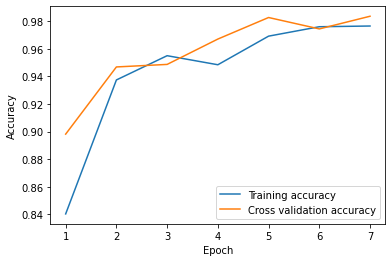

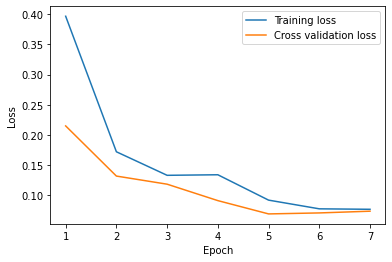

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.array([1, 2, 3, 4, 5, 6, 7])

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Cross validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Cross validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Task 1 c

### Creating a TFLite model

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Saransh\AppData\Local\Temp\tmploom37n4\assets


Saving the TFLite model locally.

In [12]:
with open("model.tflite", "wb") as m:
    m.write(tflite_model)

Saving the model locally.

In [13]:
model.save("model.h5")

### Testing

We can now test our model. First we create an `ImageDataGenerator` for our testing dataset.

In [14]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_set = test_datagen.flow_from_directory(
    './data_set/test/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 546 images belonging to 2 classes.


Next we evaluate the model.

In [15]:
model.evaluate(test_set)

18/18 [==============================] - 6s 324ms/step - loss: 0.0648 - accuracy: 0.9853


[0.06475543975830078, 0.9853479862213135]

Now we can pull up a random image from our testing dataset and predict if the eye is open or close.

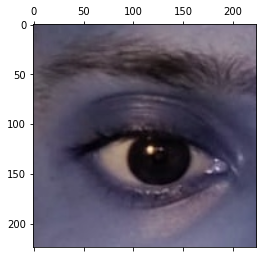

In [16]:
# loading an image
img = cv2.imread(r"data_set\test\Open\_0.jpg")
img = cv2.resize(img, (224, 224))

# displaying the image
plt.matshow(img)

Predicting the label. 0 = Close | 1 = Open

In [17]:
img = img / 255.0
y_pred = model.predict(np.array([img]))

In [18]:
np.argmax(y_pred.flatten())

1

Looking at the predicted probabilities

In [19]:
y_pred

array([[6.209059e-12, 1.000000e+00]], dtype=float32)

The trained model is used to detect drowsiness through a video feed in [detect_drowsiness.py]().